# How to work for small dataset (cifar 60000 is still small dataset, CNN is trained on millions images)
In the situation where you don't have millions of images it is difficult to train a CNN from scratch that performs very well. This is why we will learn about a few techniques we can use to train CNN's on small datasets of just a few thousand images. 
- 1. **Data agumentation** to avoid overfitting and increase number of dataset --> check CNN_Deep_Learning.ipynb
- 2. **Pre-trained model** if both dataset are similar with  **Fine tunning** by using transfer learning from one model (trained on largse dataset) to new model(which has only small dataset) 

##2. **Pre-trained Models**
You would have noticed that the model above takes a few minutes to train in the NoteBook and only gives an accuaracy of ~70%. This is okay but surely there is a way to improve on this. 

We can also use a pretrained CNN as apart of our own custom network to improve the accuracy of our model. We know that CNN's alone (with no dense layers) don't do anything other than map the presence of features from our input. This means we can use a pretrained CNN, one trained on millions of images, as the start of our model. This will allow us to have a very good convolutional base before adding our own dense layered classifier at the end. In fact, by using this techique we can train a very good classifier for a realtively small dataset (< 10,000 images). This is because the convnet already has a very good idea of what features to look for in an image and can find them very effectively. So, if we can determine the presence of features all the rest of the model needs to do is determine which combination of features makes a specific image.



### **Fine Tuning**
When we employ the pre-trained technique, we will often want to tweak the final layers in our convolutional base to work better for our specific problem. This involves not touching or retraining the earlier layers in our convolutional base but only adjusting the final few. We do this because the first layers in our base are very good at extracting low level features lile lines and edges, things that are similar for any kind of image. Where the later layers are better at picking up very specific features like shapes or even eyes. If we adjust the final layers than we can look for only features relevant to our very specific problem.





# Using a Pretrained Model
- use a pretrained model and fine tuning to classify images of dogs and cats using a small dataset.

- help:  https://www.tensorflow.org/tutorials/images/transfer_learning*


# setup and imports

In [1]:
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

## dataset
- Load the *cats_vs_dogs* dataset from the modoule tensorflow_datatsets.

- This dataset contains (image, label) pairs where images have different spatial dimensions than CIFAR 10(32x32) and 3 color channels.



In [2]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()


# split dataset into train, validation and test

(raw_train, raw_validation, raw_test), metadata = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], 
                                                            with_info=True, as_supervised=True ) # train 0-80%, validation- 80% to 90%, test = 90% to 100%



Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete42VCEN/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


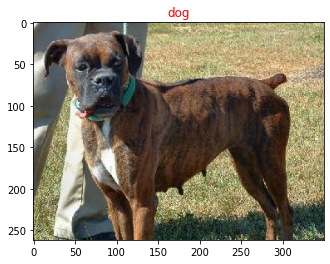

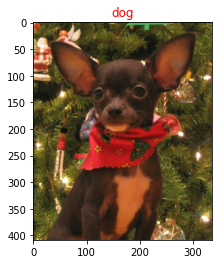

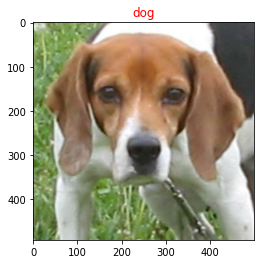

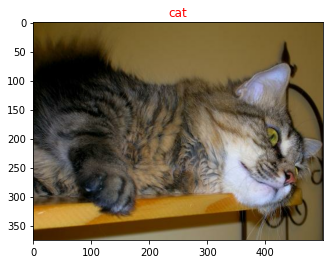

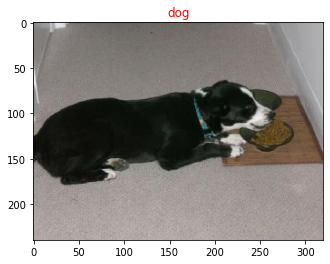

In [3]:
# creates a function object that we can use to get labels

get_label_name = metadata.features['label'].int2str  


# display 5 images from the dataset
for image, label in raw_train.take(5): # image 0, 1,2,3,4
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label), color ='r')

###Data Preprocessing
Since the sizes of our images are all different, we need to convert them all to the same size. 



In [4]:
img_size = 160 # All images will be resized to 160x160

def resize_format(image, label):
   '''
   return an image that is reshaped with img_size
   '''

   image = tf.cast(image, tf.float32) # converting pixel value into float, bcz we need to divide with float number 127.5
   image = (image/127.5) - 1
   image = tf.image.resize(image, (img_size, img_size))
   return image, label





In [5]:
# passing the above image size into all images --> with map() method

train = raw_train.map(resize_format)
validation = raw_validation.map(resize_format)
test = raw_test.map(resize_format)

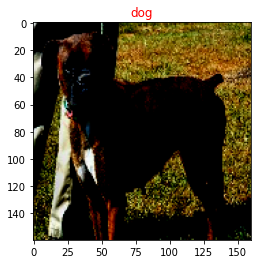

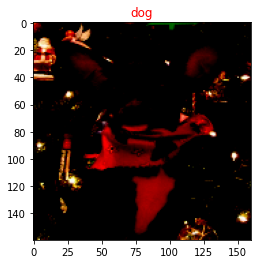

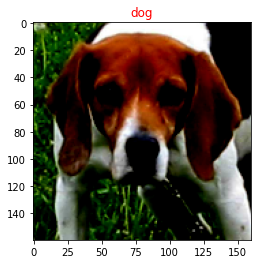

In [6]:
for image, label in train.take(3):
  plt.figure()
  plt.imshow(image, cmap= plt.cm.binary)
  plt.title(get_label_name(label), color = 'r')

In [7]:
# shuffle the train images 

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)


# just too check original and new img shape

for img, label in raw_train.take(3): # images are in diferent size
  print('original shape', img.shape)


for img, label in train.take(3): # all images are in same size now
  print('original shape', img.shape)

original shape (262, 350, 3)
original shape (409, 336, 3)
original shape (493, 500, 3)
original shape (160, 160, 3)
original shape (160, 160, 3)
original shape (160, 160, 3)


###Picking a Pretrained Model
The model we are going to use as the convolutional base for our model is the **MobileNet V2** developed at Google. This model is trained on 1.4 million images and has 1000 different classes.

We want to use this model but only its convolutional base. So, when we load in the model, we'll specify that we don't want to load the top (classification) layer. We'll tell the model what input shape to expect and to use the predetermined weights from *imagenet* (Googles dataset).



In [8]:
IMG_SHAPE = (img_size, img_size, 3) # img_size = 160 defined above

# base model creation with Imagenet dataset using MobileNetV2 architecture  

base_model = tf.keras.applications.MobileNetV2(input_shape= IMG_SHAPE, include_top=False,
                                               weights='imagenet')




9420800/9406464 [==============================] - 0s 0us/step


In [9]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

At this point this base_model will simply give output of a shape (32, 5, 5, 1280) tensor that is a feature extraction from our original (1, 160, 160, 3) image -->1 means 1 full image. The 32 means that we have 32 layers of differnt filters/features.

In [10]:
for image, _ in train_batches.take(1):
   pass

feature_batch = base_model(image)
print(feature_batch.shape)

(32, 5, 5, 1280)


###Freezing the Base
The term **freezing** refers to disabling the training property of a layer. It simply means we won’t make any changes to the weights of any layers that are frozen during training. This is important as we don't want to change the convolutional base that already has learned weights.



In [11]:
base_model.trainable = False

In [12]:
base_model.summary()


# now we have Trainable params: 0 --> no traing time time as base model has been already trained


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

###Adding our Classifier
Now that we have our base layer setup, we can add the classifier. Instead of flattening the feature map (5,5,1280) of the base layer we will use a global average pooling layer that will average the entire 5x5 area of each 2D feature map and return to us a single 1280 element vector per filter.  



In [13]:
# take global average pooling from each 1280 layers from each filter(total 32 filter) which has 5*5 image shape and convert into 1D as flatten

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()





Finally, we will add the predicition layer that will be a single dense neuron. We can do this because we only have two classes to predict for.




In [14]:
prediction_layer = keras.layers.Dense(1)

Now we will combine these layers together in a model.




In [15]:
model = tf.keras.Sequential([ base_model, global_average_layer, prediction_layer])
                             

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


###Training the Model
Now we will train and compile the model. We will use a very small learning rate to ensure that the model does not have any major changes made to it.

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [18]:
# We can evaluate the model right now to see how it does before training it on our new images
initial_epochs = 20
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 4s 80ms/step - loss: 0.7195 - accuracy: 0.4984


In [19]:
# Now we can train it on our train and validation images batch
model_train = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

acc = model_train.history['accuracy'] # saving accuracy as a list from all epochs
print(acc)

Epoch 1/20
582/582 [==============================] - 78s 124ms/step - loss: 0.2126 - accuracy: 0.9092 - val_loss: 0.0856 - val_accuracy: 0.9690
Epoch 2/20
582/582 [==============================] - 69s 114ms/step - loss: 0.0741 - accuracy: 0.9737 - val_loss: 0.0619 - val_accuracy: 0.9785
Epoch 3/20
582/582 [==============================] - 69s 114ms/step - loss: 0.0595 - accuracy: 0.9778 - val_loss: 0.0542 - val_accuracy: 0.9785
Epoch 4/20
582/582 [==============================] - 70s 117ms/step - loss: 0.0534 - accuracy: 0.9795 - val_loss: 0.0501 - val_accuracy: 0.9815
Epoch 5/20
582/582 [==============================] - 71s 118ms/step - loss: 0.0498 - accuracy: 0.9812 - val_loss: 0.0479 - val_accuracy: 0.9819
Epoch 6/20
582/582 [==============================] - 71s 119ms/step - loss: 0.0474 - accuracy: 0.9822 - val_loss: 0.0460 - val_accuracy: 0.9824
Epoch 7/20
582/582 [==============================] - 69s 115ms/step - loss: 0.0454 - accuracy: 0.9831 - val_loss: 0.0449 - val_ac

In [20]:
model.save("dogs_vs_cats.h5")  # we can save the model and reload it at anytime in the future
new_model = tf.keras.models.load_model('dogs_vs_cats.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


##Object Detection
If you'd like to learn how you can perform object detection and recognition with tensorflow check out the guide below.

https://github.com/tensorflow/models/tree/master/research/object_detection